# Illinois Gambling Analysis
> Using Hierarchical Linear Modeling to infer the relationship between video gambling terminals and casino tax revenue at the municipal level.

## Purpose

In this notebook I use hierarchical linear models to evaluate the relationship between the number of video gambling terminals within a municipality and the public funds that result from casino revenue while controlling for differences in population between communities. By using hierarchical models, as opposed to the standard Ordinary Least Squares method, I am able to infer the average impact that terminal count has on resulting tax revenue, and the variance that can be expected across communities. 

### Running the code

#### Virtual Environment

To ensure you have all required packages for this notebook, an environment.yml file has been provided [here]().
Follow the set-up instructions [here]() to create and activate the environment.

------

#### Data Collection

The code used for collecting the gambling data can be found [here]()

The code used for collecting census variables can be found [here]()

------

In [1]:
# Notebook Imports
import os
import sys
from IPython.display import display, Markdown
parent = os.path.join(os.pardir)
sys.path.append(parent)

# Data Manipulation
import psycopg2
import pandas as pd
import numpy as np
import string
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns

# Models
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Model Evaluation
from src.Modeling import Assumptions
from sklearn.metrics import r2_score, mean_squared_error


# Database connection
conn = psycopg2.connect(dbname="illinois_gambling")

# Helper functions
def query(query):
    return pd.read_sql(query, conn)

def subplot_map(idx, columns):
    return (idx//columns, idx%columns)

def multi_level(formula, group_name, data):
    model_data = data.copy()
    model = sm.MixedLM.from_formula(formula, 
                                    groups=group_name,
                                    data=model_data)
    model = model.fit()
    return model

## Background

Video gambling was legalized by the state of Illinois in 2009, with the first machines activated in September of 2012. Since then the number of towns that have installed video gambling machines has increased every year.
> **Note:** All video gambling activities were suspended from April 2020-June 2020 to mitigate transmission of COVID19. While data for 2020 has been reported by the [Illinois Gaming Board](https://www.igb.illinois.gov/) these data require further clarification by the Illinois Gaming Board before they can be confidently analyzed. Because of this, 2020 data  is largely excluded from this analysis and excluded entirely from the models developed in this notebook. 

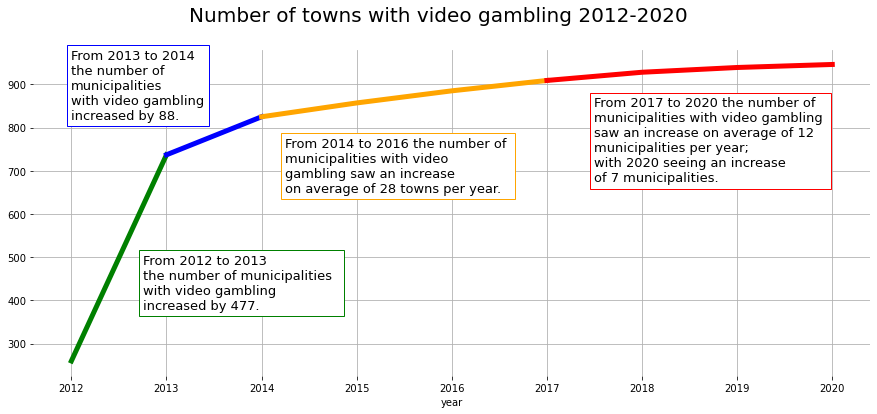

In [2]:
### Visualization Code
q = '''SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
              count(DISTINCT municipality.name) as num_of_towns
       FROM municipality
       INNER JOIN video_gambling
       ON municipality.name = video_gambling.municipality
       GROUP BY date_part('year', video_gambling.date);'''

query_results = query(q).set_index('year')
fig, ax = plt.subplots()
query_results.loc[:2013].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='green')
query_results.loc[2013:2014].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='blue')
query_results.loc[2014:2017].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='orange')
query_results.loc[2017:].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='red')
# axes[0].set_yticks(query_results.num_of_towns)
fig.suptitle('Number of towns with video gambling 2012-2020', fontsize=20)
ax.grid()

ax.set_frame_on(False)

first_annotation = ax.text(2012.75, 380, 
f'''From 2012 to 2013 
the number of municipalities  
with video gambling 
increased by\
 {int(query_results.loc[[2012,2013]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
first_annotation.set_bbox(dict(facecolor='white', edgecolor='green'))

second_annotation = ax.text(2012, 820, 
f'''From 2013 to 2014\nthe number of
municipalities
with video gambling\nincreased by\
 {int(query_results.loc[[2013,2014]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
second_annotation.set_bbox(dict(facecolor='white', edgecolor='blue'))

third_annotation = ax.text(2014.25, 650, f'''\
From 2014 to 2016 the number of 
municipalities with video 
gambling saw an increase\non average of \
{int(round(query_results.loc[2014:2017].num_of_towns.diff().mean()))} \
towns per year.''', dict(size=13))
third_annotation.set_bbox(dict(facecolor='white', edgecolor='orange'))

fourth_annotation = ax.text(2017.5, 675, f'''\
From 2017 to 2020 the number of
municipalities with video gambling 
saw an increase on average of \
{int(round(query_results.loc[2017:].num_of_towns.diff().mean()))} 
municipalities per year; 
with 2020 seeing an increase 
of {int(round(query_results.loc[2017:].num_of_towns.diff().loc[2020]))} municipalities.''', dict(size=13))
fourth_annotation.set_bbox(dict(facecolor='white', edgecolor='red'))

fig_path = os.path.join(os.pardir, 'static', 'video_gambling_growth_timeline.png')
fig.savefig(fig_path)

**Prior to the legalization of video gambling**, if an Illinois resident had wanted to gamble their only option was to travel to one of the few municipalities home to a casino.

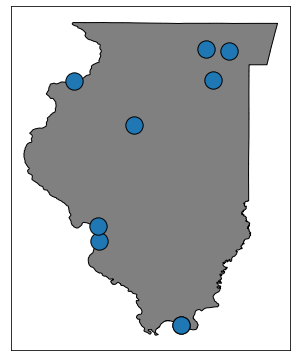

In [3]:
# Visualization Code 

q = '''SELECT DISTINCT municipality, latitude, longitude
        FROM casino;'''

towns_with_casinos = query(q)
shape_path = os.path.join(os.pardir, 'data', 'shapefiles', 'state', 'tl_2019_us_state.shp')
us = gpd.read_file(shape_path)
illinois = us[us.STUSPS == 'IL']

towns_with_casinos['latitude'] = towns_with_casinos['latitude'].astype(float)
towns_with_casinos['longitude'] = towns_with_casinos['longitude'].astype(float)

fig, ax = plt.subplots(figsize=(5, 8)) 
illinois.plot(ax=ax, color='grey', lw=1, edgecolors='black')

x, y = towns_with_casinos.longitude, towns_with_casinos.latitude
ax.scatter(x,y, edgecolors='black', s=300)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig_path = os.path.join(os.pardir, 'static', 'casino_locations.png')
fig.savefig(fig_path, bbox_inches='tight')
plt.show()

**However**, since activation of video gambling in 2012, access to gambling facilities have become widely distributed throughout the state.

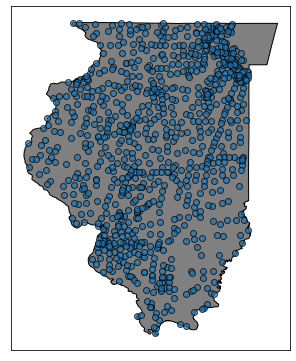

In [4]:
# Visualization Code
q = '''SELECT name, latitude, longitude, terminal_count
        FROM (
        SELECT SUM(terminal_count) as terminal_count, municipality AS name
        FROM video_gambling
        WHERE DATE_PART('year', video_gambling.date) = 2019
        AND DATE_PART('month', video_gambling.date) = 11
        GROUP BY municipality) subquery
        INNER JOIN municipality
        USING(name);
        '''
        
results = query(q)
results['latitude'] = results.latitude.astype(float)
results['longitude'] = results.longitude.astype(float)

fig, ax = plt.subplots(figsize=(5, 8)) 
illinois.plot(ax=ax, color='grey', lw=1, edgecolors='black')

x, y = results.longitude, results.latitude
ax.scatter(x,y, edgecolors='black',  alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig_path = os.path.join(os.pardir, 'static', 'terminal_locations_2019.png')
fig.savefig(fig_path,bbox_inches='tight')
plt.show()

During this same time, **Illinois has also seen a near consistent decline in casino revenue.**

In [6]:
# Data Code
video = """SELECT CONCAT(
                      CAST(CAST(DATE_PART('YEAR', video.date) AS INTEGER) AS TEXT),
                      '-',
                      CAST(CAST(DATE_PART('MONTH', video.date) AS INTEGER) AS TEXT)) AS date,
              video.municipality,
              SUM(video.terminal_count) AS terminal_count,
              SUM(video.amount_played) - SUM(video.amount_won) AS video_agr,
              SUM(video.municipality_share) AS video_local_share, 
              SUM(video.state_share) AS video_state_share
              FROM video_gambling video
              WHERE video.municipality IN (
              SELECT casino.municipality
              FROM casino)
              GROUP BY video.municipality, 
                       DATE_PART('YEAR', video.date), 
                       DATE_PART('MONTH', video.date)"""

casino = '''SELECT CONCAT(
                      CAST(CAST(DATE_PART('YEAR', casino.date) AS INTEGER) AS TEXT),
                      '-',
                      CAST(CAST(DATE_PART('MONTH', casino.date) AS INTEGER) AS TEXT)) AS date,
                   SUM(casino.adjusted_gross_receipt) AS casino_agr,
                   SUM(casino.admissions) AS admissions,
                   SUM(casino.state_share) AS casino_state_share,
                   SUM(casino.local_share) AS casino_local_share,
                   casino.municipality
                   FROM casino
                   GROUP BY casino.municipality, DATE_PART('YEAR', casino.date), DATE_PART('MONTH', casino.date);'''

yearly_demographics = f'''SELECT demo.year,
                        demo.municipality,
                        SUM(demo."B01003_001E") as population
                        FROM demographics demo
                        GROUP BY demo.year, demo.municipality'''

video_demographics = f"""SELECT demo."B01003_001E"as population,
                                demo.year,
                                demo.municipality 
                         FROM demographics demo
                   WHERE demo.year IN (
                   SELECT DATE_PART('year', video.date) as year
                   FROM video_gambling video) 
                   AND demo.municipality IN (
                   SELECT DISTINCT municipality FROM casino);"""

df = query(casino).merge(query(video), on=['municipality', 'date'], how='left')
demographics = query(yearly_demographics)

df['casino_public_funds'] = df.casino_local_share + df.casino_state_share
df['video_public_funds'] = df.video_local_share + df.video_state_share
df.date = pd.to_datetime(df.date, format='%Y-%m')
df.set_index('date', inplace=True)
df = df.loc[:'2019']
yearly = df.groupby([pd.Grouper(freq='Y'), 'municipality']).sum().reset_index().set_index('date')
yearly['year'] = [date.year for date in yearly.index]
yearly = yearly.merge(demographics, on=['year', 'municipality'])
df['year'] = [x.year for x in df.index]
# df = df.merge(query(video_demographics), on=['municipality', 'year'], right_index=True)

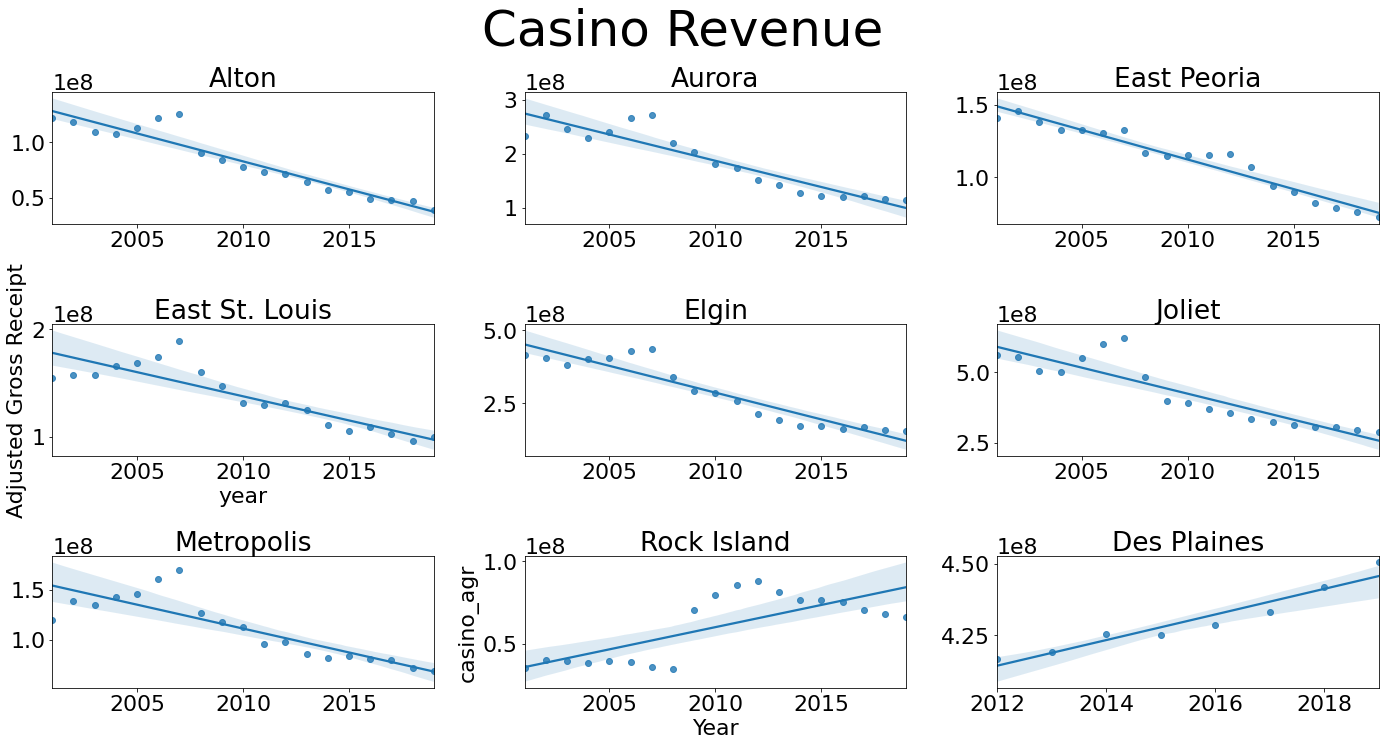

In [7]:
from matplotlib import rcParams
rcParams.update({'font.size': 22})

c =  query(casino)
c['date'] = pd.to_datetime(c.date, format='%Y-%m')
c.set_index('date', inplace=True)
c  = c.groupby([pd.Grouper(freq='Y'), 'municipality']).sum().reset_index().set_index('date')
c['year'] = [x.year for x in c.index]

figure, axes = plt.subplots(3,3, figsize=(20,10))
casinos = c.municipality.unique()
for idx in range(len(casinos)):
    frame = c[c.municipality == casinos[idx]][['casino_agr', 'year']].iloc[1:]
    frame = frame[frame.year != 2020]
    row, column = subplot_map(idx, 3)
    sns.regplot(x=frame.year, y=frame.casino_agr, ax=axes[row,column])
    axes[row, column].set_title(casinos[idx])
    if row == 1 and column == 0:
        axes[row, column].set_ylabel('Adjusted Gross Receipt')
        
    elif row == 2 and column == 1:
        axes[row, column].set_xlabel('Year')
    else:
        axes[row, column].set_xlabel('')
        axes[row, column].set_ylabel('')

# fig_path = os.path.join(os.pardir, 'static', 'casino_decline.png')
# figure.savefig(fig_path)
figure.suptitle('Casino Revenue', y=1.05, fontsize=50)
figure.tight_layout()

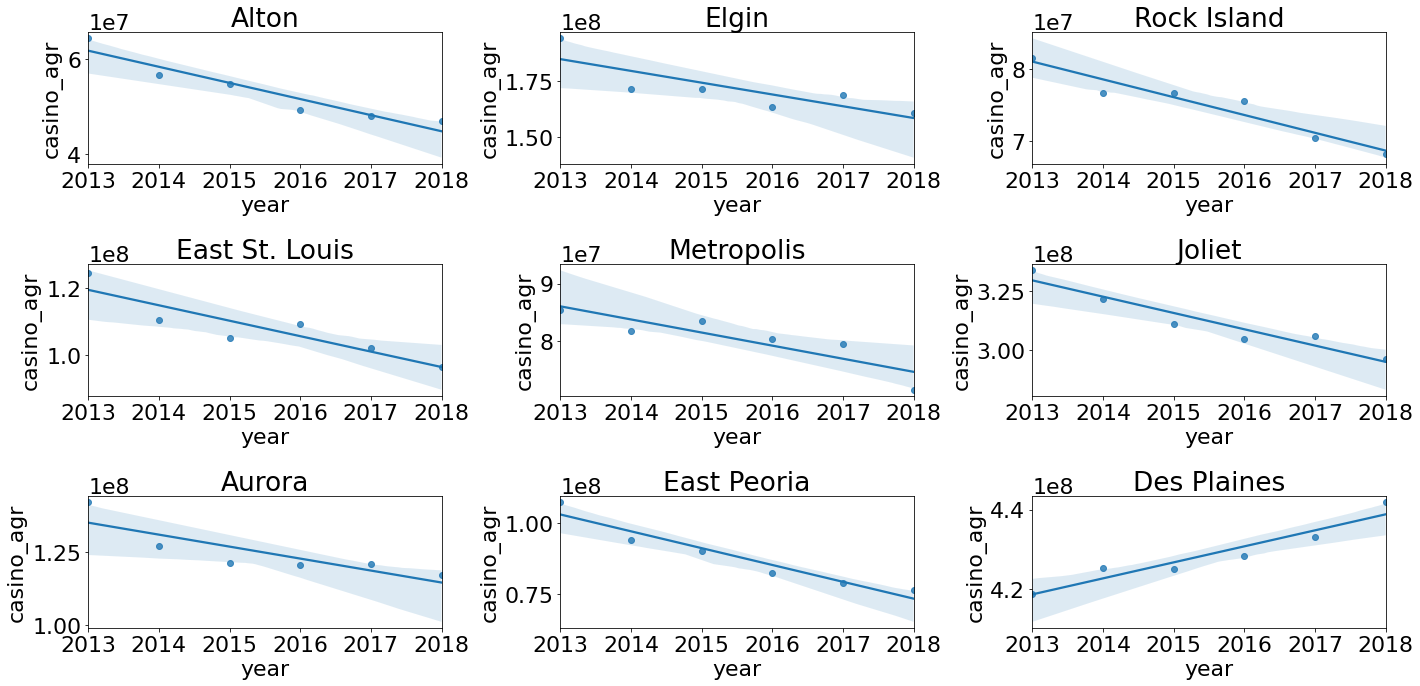

In [8]:
# Visualization Code
figure, axes = plt.subplots(3,3, figsize=(20,10))
casinos = df.municipality.unique()
for idx in range(len(casinos)):
    frame = yearly[yearly.municipality == casinos[idx]][['casino_agr', 'year']].iloc[1:]
    row, column = subplot_map(idx, 3)
    sns.regplot(x=frame.year, y=frame.casino_agr, ax=axes[row,column])
    axes[row, column].set_title(casinos[idx])
fig_path = os.path.join(os.pardir, 'static', 'casino_decline.png')
figure.savefig(fig_path)
figure.tight_layout()

Given the growth that has occurred for video gambling products, increased scrutiny was likely inevitable, but due to the decline in Casino revenue, the differing tax rates between video and casino gambling havee been frequently debated by journalists, voters, and legislators.

### Tax Breakdown

**TLDR;**
> **Casino gambling tax rates increase as revenue increases. The tax rate for video gambling is fixed.**

"*Wagering Tax Effective July 1, 2020, the wagering tax is as follows:*

<u><i>All gambling games, other than table games:</i></u>
- *15% of AGR up to and including \$25 million*
- *22.5% of AGR in excess of 25 million but not exceeding 50 million*
- *27.5% of AGR in excess of 50 million but not exceeding 75 million*
- *32.5% of AGR in excess of 75 million but not exceeding 100 million*
- *37.5% of AGR in excess of 100 million but not exceeding 150 million*
- *45% of AGR in excess of 150 million but not exceeding 200 million*
- *50% of AGR in excess of 200 million

<u><i>All table games:</i></u>
- *15% of AGR up to and including 25 million*
- *20% of AGR in excess of 25 million"*
> -[Illinois Gaming Board](https://www.igb.illinois.gov/CasinoFAQ.aspx#:~:text=The%20Illinois%20Gambling%20Act%20imposes,and%20a%20tax%20on%20admissions.&text=The%20admissions%20tax%20was%20increased,person%20to%20%243%20a%20person.)

/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


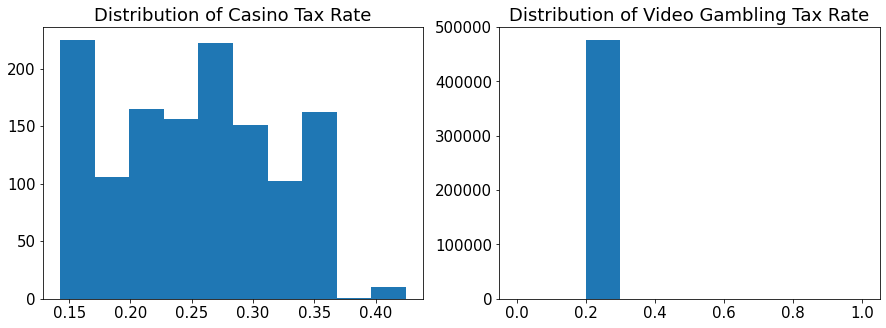

In [9]:
# Visualization Code
rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1,2, figsize=(15,5))

q = """SELECT state_share, local_share, adjusted_gross_receipt, DATE_PART('year', date) as year
           FROM casino"""

casino_tax_rate = query(q)
public_dollars = (casino_tax_rate.local_share + casino_tax_rate.state_share)
casino_tax_rate['tax_rate'] = public_dollars/(public_dollars + casino_tax_rate.adjusted_gross_receipt)
axes[0].hist(casino_tax_rate[casino_tax_rate.year < 2012].tax_rate)
axes[0].set_title('Distribution of Casino Tax Rate')


q = """SELECT state_share, municipality_share, net_terminal_income
       FROM video_gambling;"""

video_tax_rate = query(q)
public_dollars = video_tax_rate.state_share + video_tax_rate.municipality_share
video_tax_rate['rate'] = public_dollars/(video_tax_rate.net_terminal_income + public_dollars)

plt.title('Distribution of Video Gambling Tax Rate')
axes[1].hist(video_tax_rate.rate);

<u>Ultimately, the debate tends to go as followed:</u>

**Person A:** "Video gambling is cutting into casino revenue, and casino revenue is taxed at a greater rate than video gambling so video gambling is bad for my community."

**Person B:** "Video gambling has a fixed tax rate, but casino gambling is frequently taxed at half the rate of video gambling, so video gambling is good for my community."

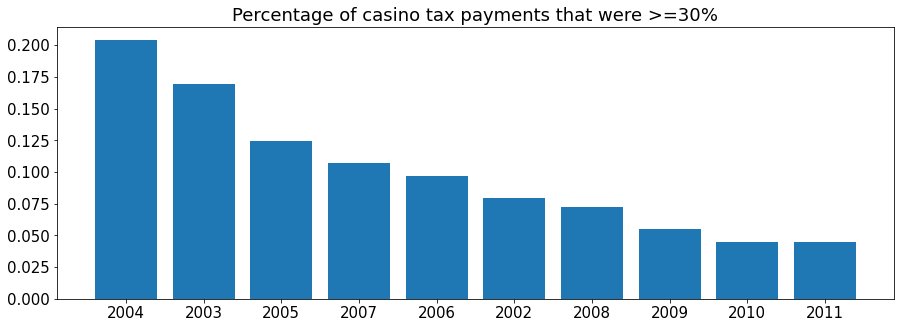

In [10]:
# Visualization Code
series = casino_tax_rate[(casino_tax_rate.tax_rate >= .3) & (casino_tax_rate.year < 2012)].year.value_counts(normalize=True)
plt.figure(figsize=(15,5))
plt.bar([str(int(x)) for x in series.index], series.values)
plt.title('Percentage of casino tax payments that were >=30%');

While it is true that casino revenue is in decline, in the case of tax rates higher than that of video gambling, this decline has been consistent since 2003. Because the first video gambling terminals did not go live until 2012, it is not accurate to say the introduction of video gambling is the sole driver of the decline in higher tax payments from casinos.

This however is neither evidence in support or against the suggestion that video gambling leads to less public funds. **So does it?** To determine this we must ask ourselves, *what is the relationship between video gambling and casino tax revenue? On average, what happens to casino tax revenue when new video gambling terminals are introduced to a community?*

These are questions for which linear regression is well suited. But for this problem OLS which assumes independence across observation would ignore the inherent correlation that exists within municipalities. The mean and standard deviations of terminal counts and tax revenue in one municipality are likely to differ drastically from municipalities with higher populations. For this reason, I will use multi level linear regression which controls for intercluster correlation and allows the adding of random intercepts and slopes for relevant parameters. Ultimately this gives me the ability to account for multiple stratifications of dependence within my model.

## The data

The data for this project consists of casino and video gambling monthly reports and census data that was collected for each municipality using the 5 Year American Community Survey (ACS). The monthly reports were collected with a selenium web scraper and all data was inserted into a postgresql `illinois_gambling` database. 

The source code for data collection can be found [here](../src/scrape.py)

### Data Preparation

Let's start by checking the shape of our data, and inspecting the first five rows.

In [11]:
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

The data has 2022 rows and 12 columns


,casino_agr,admissions,casino_state_share,casino_local_share,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_public_funds,video_public_funds,year
date,,,,,,,,,,,,
2006-06-01,9645000.0,119524.0,2409000.0,602000.0,Alton,NaN,NaN,NaN,NaN,3011000.0,NaN,2006
2017-01-01,13036727.0,104332.0,1512337.0,756168.0,Elgin,NaN,NaN,NaN,NaN,2268505.0,NaN,2017
2013-09-01,6668491.0,99845.0,1600255.0,433270.0,Rock Island,53.0,95798.96,4790.00,23949.94,2033525.0,28739.94,2013
2015-11-01,8067160.0,92627.0,2403723.0,495985.0,East St. Louis,NaN,NaN,NaN,NaN,2899708.0,NaN,2015
2013-12-01,5860622.0,42565.0,1696801.0,335596.0,Metropolis,5.0,39099.49,1954.97,9774.88,2032397.0,11729.85,2013


In it's current form, these data are not ready for modeling. 

**Let's begin by inspecting null values.** 

These data were created with a left join, using the casino table as the left table, so for any date a municipality does not have video gambling data, those cells are `Null`. Let's fill null values in the `terminal_count` column with zero, and plot the count across years.

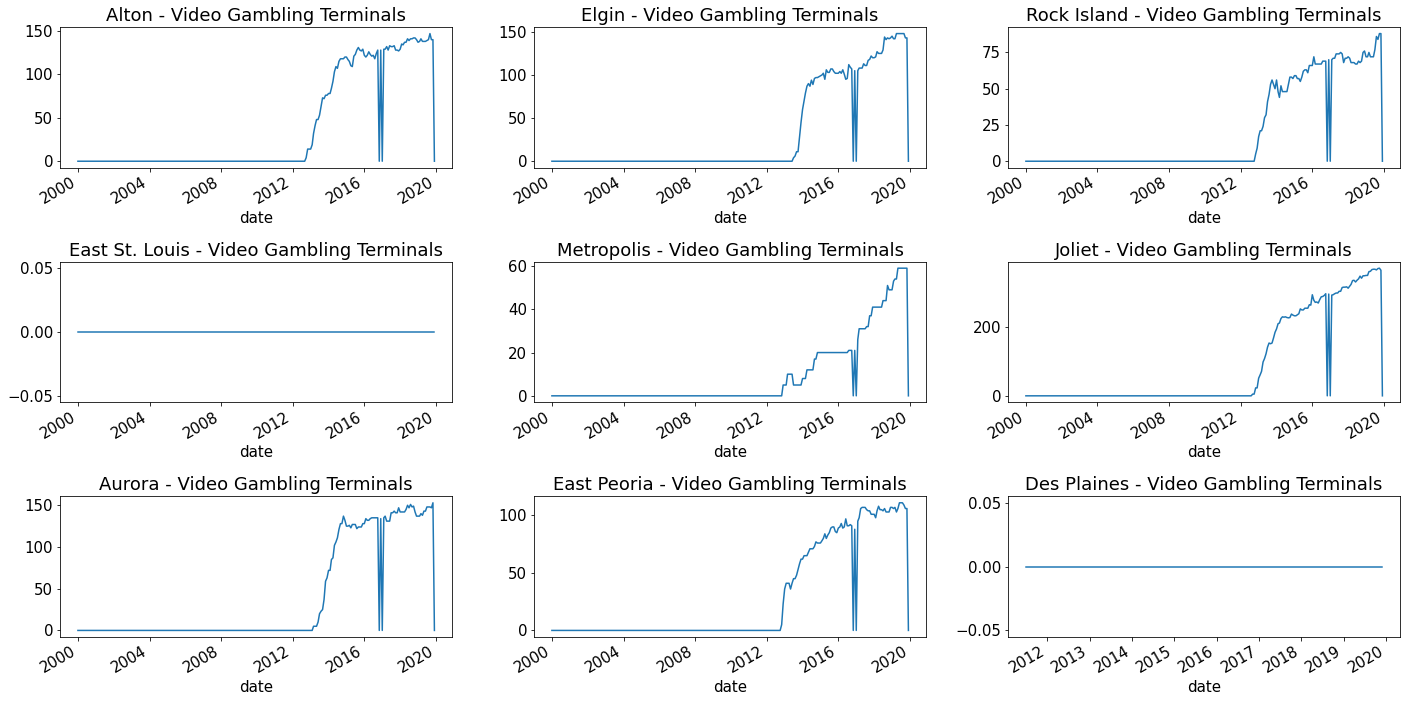

In [12]:
def subplot_map(idx, columns):
    return (idx//columns, idx%columns)
rcParams.update({'font.size': 15})
towns = df.municipality.unique()

rows = 3
columns = 3

fig, axes = plt.subplots(rows, columns, figsize=(20,10))

for idx in range(len(towns)):
    town = towns[idx]
    row, column = subplot_map(idx, columns)
    ax = axes[row, column]
    df[df.municipality ==town].fillna(0).terminal_count.plot(ax=ax)
    ax.set_title(f'{town} - Video Gambling Terminals')
fig.tight_layout()

It looks like we have some null values that are appearing near the end  of 2016 for each municipality with video gambling. Let's check this out by inspecting the data for Alton.

In [13]:
df[df.municipality == 'Alton'].loc['2016':'2017'].head(7)

,casino_agr,admissions,casino_state_share,casino_local_share,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_public_funds,video_public_funds,year
date,,,,,,,,,,,,
2017-04-01,4230709.0,41951.0,506973.0,253486.0,Alton,132.0,538243.61,26911.73,134559.05,760459.0,161470.78,2017
2016-09-01,4195812.0,45551.0,825369.0,255342.0,Alton,124.0,388064.97,19403.39,97017.02,1080711.0,116420.41,2016
2017-03-01,4592994.0,46492.0,552283.0,276142.0,Alton,129.0,595805.10,29790.95,148955.03,828425.0,178745.98,2017
2017-01-01,3740989.0,37128.0,448355.0,224177.0,Alton,NaN,NaN,NaN,NaN,672532.0,NaN,2017
2017-02-01,4055476.0,41615.0,488778.0,244389.0,Alton,129.0,498509.71,24925.61,124628.30,733167.0,149553.91,2017
2016-11-01,3749289.0,39878.0,735882.0,227342.0,Alton,NaN,NaN,NaN,NaN,963224.0,NaN,2016
2016-04-01,4317689.0,46374.0,524517.0,262258.0,Alton,126.0,428933.39,21446.81,107234.22,786775.0,128681.03,2016


For Alton, we have null values for dates 11/2016 and 01/2017.

Let's see if this is true for the remaning municipalities.

In [14]:
df.loc[['2016-11-01', '2017-01-01']].terminal_count.unique()

array([nan])

It looks like these days are null for every municipality. We will go ahead and fill these values with the terminal count from the previous time step

In [15]:
df = df.reset_index()
for idx, row in df.iterrows():
    municipality = row.municipality
    filter_1 = (df.municipality == municipality)
    if row.date.year == 2016 and row.date.month == 11:
        filter_2 = (df.date == '2016-10-01')
        last_count = df[filter_1 & filter_2].terminal_count.iloc[0]
        df.at[idx, 'terminal_count'] = last_count
    elif row.date.year == 2017 and row.date.month == 1:
        filter_2 = (df.date == '2016-12-01')
        last_count = df[filter_1 & filter_2].terminal_count.iloc[0]
        df.at[idx, 'terminal_count'] = last_count

Now let's check to see if the null values have been filled

In [16]:
df[df.date.isin(['2016-11-01', '2017-01-01'])].terminal_count.unique()

array([105.,  91., 107., 128.,  69.,  nan, 135., 295.,  88., 296., 134.,
        21.,  70.])

It looks like we still have some null values, but I'm going to guess that these values are for the towns East St. Louis and Des Plaines which do not seem to have any video gambling. Let's check.

In [17]:
towns_with_nulls = df[(df.date.isin(['2016-11-01', '2017-01-01'])) & df.terminal_count.isna()].municipality.unique()
print(towns_with_nulls)

['East St. Louis' 'Des Plaines']


Cool, let's drop these municipalities from the data

In [18]:
df = df[~df.municipality.isin(towns_with_nulls)]
df.head()

,date,casino_agr,admissions,casino_state_share,casino_local_share,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_public_funds,video_public_funds,year
0,2006-06-01,9645000.0,119524.0,2409000.0,602000.0,Alton,NaN,NaN,NaN,NaN,3011000.0,NaN,2006
1,2017-01-01,13036727.0,104332.0,1512337.0,756168.0,Elgin,105.0,NaN,NaN,NaN,2268505.0,NaN,2017
2,2013-09-01,6668491.0,99845.0,1600255.0,433270.0,Rock Island,53.0,95798.96,4790.00,23949.94,2033525.0,28739.94,2013
4,2013-12-01,5860622.0,42565.0,1696801.0,335596.0,Metropolis,5.0,39099.49,1954.97,9774.88,2032397.0,11729.85,2013
5,2015-05-01,27851478.0,233430.0,6436220.0,1626004.0,Joliet,252.0,919795.63,45990.09,229951.30,8062224.0,275941.39,2015


Let's check the shape of our data. How many rows did we lose?

In [19]:
df.shape

(1680, 13)

**We lost 342 rows.** Not great, but since we dropped entire towns instead of individual rows, the integrity of these data should still be in tact.

**Before we move on,** let's replot the terminal counts and make sure they look ok

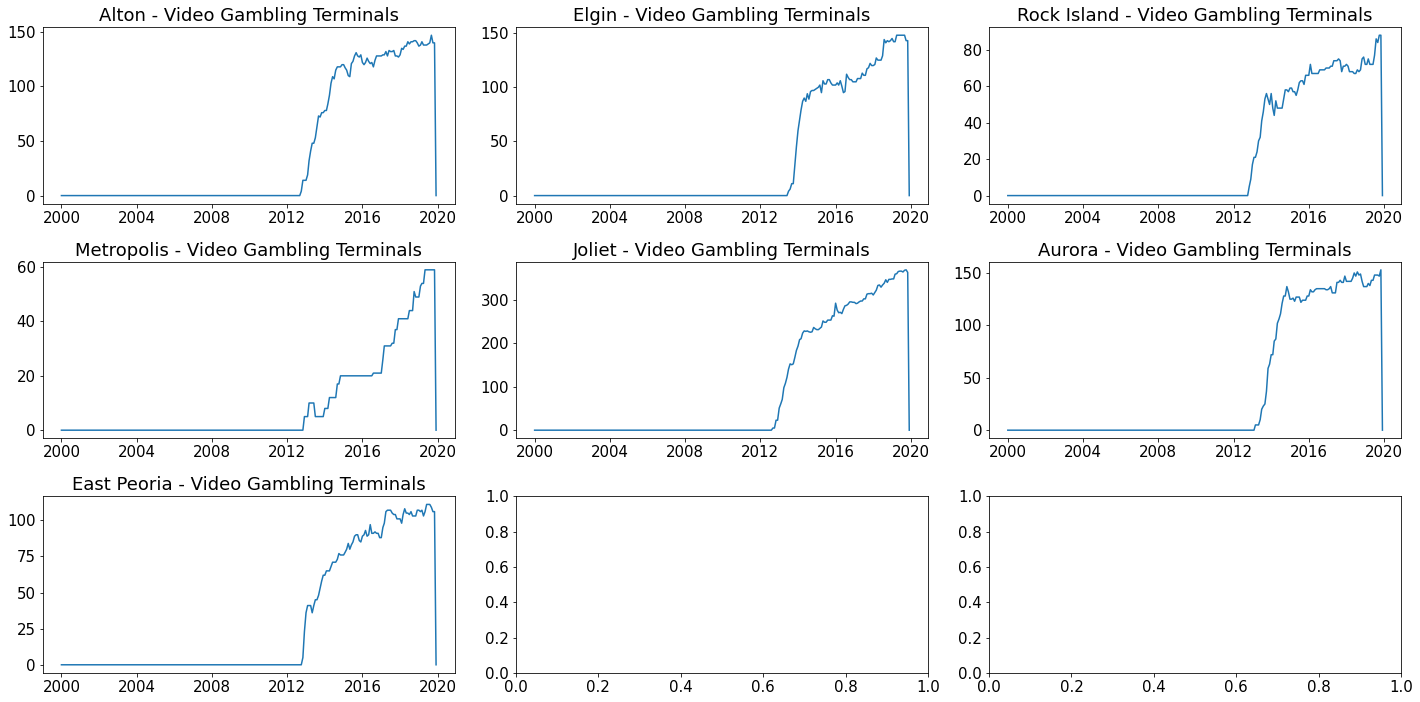

In [20]:
rcParams.update({'font.size': 15})
towns = df.municipality.unique()

rows = 3
columns = 3

fig, axes = plt.subplots(rows, columns, figsize=(20,10))

for idx in range(len(towns)):
    town = towns[idx]
    row, column = subplot_map(idx, columns)
    ax = axes[row, column]
    frame = df[df.municipality ==town].fillna(0)
    frame.sort_values(by='date', inplace=True)
    x = frame.date
    y = frame.terminal_count
    ax.plot(x,y)
    ax.set_title(f'{town} - Video Gambling Terminals')
fig.tight_layout()

It looks like there is something weird going on for the most recent observations. Let's see what happens if we remove the maximum date value from the data.

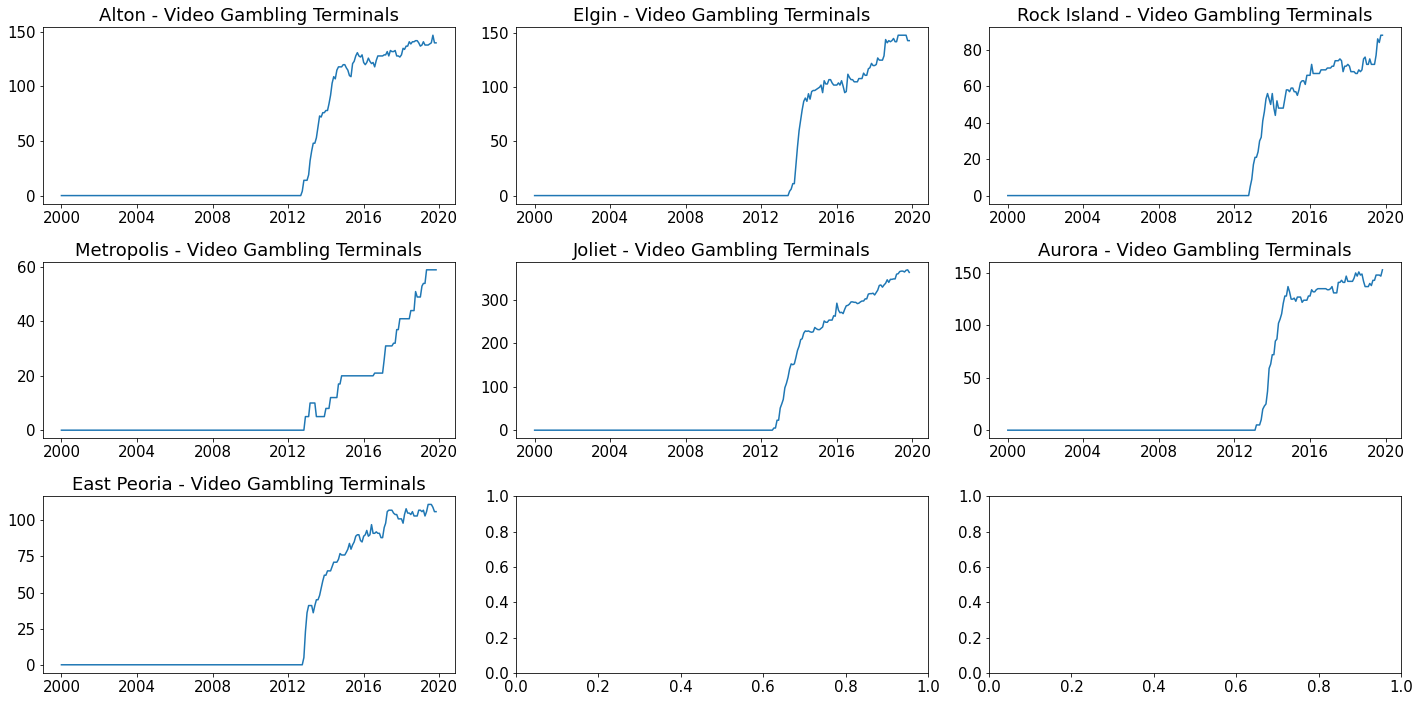

In [21]:
rcParams.update({'font.size': 15})
towns = df.municipality.unique()

rows = 3
columns = 3

fig, axes = plt.subplots(rows, columns, figsize=(20,10))
maximum_date = df.date.max()
for idx in range(len(towns)):
    town = towns[idx]
    row, column = subplot_map(idx, columns)
    ax = axes[row, column]
    frame = df[(df.municipality ==town) & (df.date < maximum_date)].fillna(0)
    frame.sort_values(by='date', inplace=True)
    x = frame.date
    y = frame.terminal_count
    ax.plot(x,y)
    ax.set_title(f'{town} - Video Gambling Terminals')
fig.tight_layout()

That looks much better. I've found this is relatively common with recent days of data in a dataset. They often times have unreported numbers or are more likely to contain some sort of data corruption. **Let's remove this date from the overall dataset.**

In [22]:
df = df[df.date < df.date.max()]

In [23]:
df.shape

(1673, 13)

**We lost seven observations.** One for each municipality.

Ok, let's isolate  the `date`, `terminal_count`, `municipality`, and `casino_agr` columns

In [24]:
modeling_data = df[['date','terminal_count', 'municipality','casino_agr']]

Have we removed all null values?

In [25]:
modeling_data.isna().sum()

date                 0
terminal_count    1088
municipality         0
casino_agr           0
dtype: int64

My understanding is that all the null values in `terminal_count` are from dates when videoo gambling was not legalized (ie, before 2012). Let's confirm this before we fill these values.

In [26]:
modeling_data[modeling_data.date < '2012-01-01'].isna().sum().terminal_count

1008

Almost true. Let's check out the null values that occur after 2012. My guess is this is happening because some municipalities did not have terminals *immediately* at the start of 2012. 

**Let's examine the range of dates for null values at or beyond 2012-01-01.**

In [27]:
nulls_after_2012 = modeling_data[(modeling_data.date >= '2012-01-01') & (modeling_data.terminal_count.isna())]
print('Mean date of null values:', nulls_after_2012.date.mean())
print('Minimum date of null values:', nulls_after_2012.date.min())
print('Maximum date of null values:', nulls_after_2012.date.max())

Mean date of null values: 2012-06-21 05:42:00
Minimum date of null values: 2012-01-01 00:00:00
Maximum date of null values: 2013-06-01 00:00:00


-----

The range is centered in 2012. The distribution for these dates is right skewed (Right of the mean has a range of 1 year while left of mean has a range of .5 years), but this fits with the timeline for legalaization.

-----

These findings coupled with the visualizations above provide sufficient evidence for replacing these null values with zero.

In [28]:
modeling_data = modeling_data.fillna(0)

# Modeling

In [29]:
modeling_data

,date,terminal_count,municipality,casino_agr
0,2006-06-01,0.0,Alton,9645000.0
1,2017-01-01,105.0,Elgin,13036727.0
2,2013-09-01,53.0,Rock Island,6668491.0
4,2013-12-01,5.0,Metropolis,5860622.0
5,2015-05-01,252.0,Joliet,27851478.0
...,...,...,...,...
2016,2010-07-01,0.0,Alton,6848000.0
2017,2006-08-01,0.0,Metropolis,13166000.0
2019,2007-11-01,0.0,East Peoria,10369000.0
2020,2003-03-01,0.0,East Peoria,13140000.0


**Let's begin by creating a baseline model.**

- This model will use the `casino_agr`  as the dependent variable and `terminal_count` as the predictor. 
    - For the baseline model, we will not apply any scaling.

- We will use normal OLS before developing the multi level model to get a sense for the dependence in the data. 

- The model will use `municipality` as the groups for the multilevel model.

**Baseline OLS**

In [30]:
formula = 'casino_agr~terminal_count'
baseline_data = modeling_data.copy()
baseline_ols = ols(formula, data=baseline_data).fit()
baseline_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             casino_agr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.041
Date:                Sun, 11 Apr 2021   Prob (F-statistic):             0.0446
Time:                        19:43:35   Log-Likelihood:                -29606.
No. Observations:                1673   AIC:                         5.922e+04
Df Residuals:                    1671   BIC:                         5.923e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.552e+07   3.26e+05     47.586      0.000    1.49e+07    1.62e+07
terminal_count -8136.8348   4047.698     -2.010      0.045   -1.61e+04    -197.741
==============================================================================
Omnibus:                      323.901   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              533.709
Skew:                           1.313   Prob(JB):                    1.28e-116
Kurtosis:                       3.875   Cond. No.                         91.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Baseline Multi-Level**

In [31]:
formula = 'casino_agr~terminal_count'
baseline_data = modeling_data.copy()
baseline_multilevel = multi_level(formula, 'municipality', baseline_data)
baseline_multilevel.summary()                                                

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                     MixedLM        Dependent Variable:        casino_agr         
No. Observations:          1673           Method:                    REML               
No. Groups:                7              Scale:                     17065984642886.9277
Min. group size:           239            Log-Likelihood:            -27861.7807        
Max. group size:           239            Converged:                 Yes                
Mean group size:           239.0                                                        
----------------------------------------------------------------------------------------
                        Coef.          Std.Err.      z    P>|z|    [0.025      0.975]   
----------------------------------------------------------------------------------------
Intercept               17370155.599  4676207.132   3.715 0.000 8204958.035 26535353.162
terminal_count            -56397.691     1518.862 -37.132 0.000  -59374.606   -53420.775
municipality Var 152973226894832.906 21270928.734                                       
========================================================================================

"""

|    |   rainbow_stat |   rainbow_p |   lagrange_multiplier |    f_stat_p |          ss |
|---:|---------------:|------------:|----------------------:|------------:|------------:|
|  0 |        1.00871 |    0.450152 |                   nan | 1.50416e-10 | 2.29948e+17 |


# Baseline OLS

**formula:** `casino_agr~terminal_count`

### Assumptions
- Linearity Assumption was **met** (p > 0.05)
- Homoscedasticity was **violated** (p < 0.05)

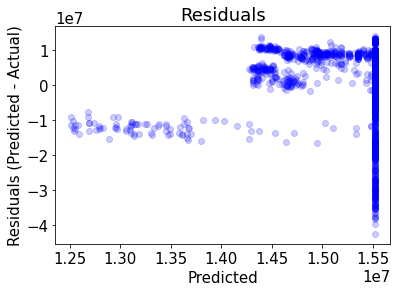

In [32]:
baseline_ols_assumptions = Assumptions(baseline_ols, modeling_data, 'Baseline OLS')
baseline_ols_assumptions.check()

|    |   rainbow_stat |   rainbow_p |   lagrange_multiplier |    f_stat_p |         ss |
|---:|---------------:|------------:|----------------------:|------------:|-----------:|
|  0 |       0.992582 |    0.542885 |                   nan | 2.50153e-63 | 2.4951e+17 |


# Baseline Multi Level

**formula:** `casino_agr~terminal_count`

### Assumptions
- Linearity Assumption was **met** (p > 0.05)
- Homoscedasticity was **violated** (p < 0.05)

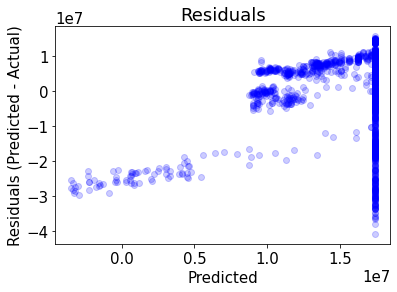

In [33]:
baseline_multilevel_assumptions = Assumptions(baseline_multilevel, modeling_data, 'Baseline Multi Level')
baseline_multilevel_assumptions.check()

In [34]:
differenced = pd.DataFrame()
for town in modeling_data.municipality.unique():
    frame = modeling_data[modeling_data.municipality == town].sort_values(by='date')
    frame[['terminal_count', 'casino_agr_diff']] = frame[['terminal_count', 'casino_agr']].diff(1)
    shifted = frame[['terminal_count','casino_agr_diff']].iloc[:-1].to_numpy()
    shifted = np.vstack(([[np.nan,np.nan]], shifted))
    frame[['terminal_count','casino_agr_diff']] = shifted
    frame = frame.dropna()
    differenced = differenced.append(frame)  
differenced.reset_index(drop=True, inplace=True)

In [38]:
second_formula = 'casino_agr~terminal_count + casino_agr_diff'
second_model_data = differenced.copy()
second_model = multi_level(second_formula, 'municipality', second_model_data)
second_model.summary()   

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                    MixedLM        Dependent Variable:        casino_agr         
No. Observations:         1659           Method:                    REML               
No. Groups:               7              Scale:                     29808925100080.9727
Min. group size:          237            Log-Likelihood:            -28086.3331        
Max. group size:          237            Converged:                 Yes                
Mean group size:          237.0                                                        
---------------------------------------------------------------------------------------
                        Coef.          Std.Err.     z    P>|z|    [0.025      0.975]   
---------------------------------------------------------------------------------------
Intercept               15460387.429  4261881.492  3.628 0.000 7107253.198 23813521.660
terminal_count           -416806.541    45661.153 -9.128 0.000 -506300.756  -327312.326
casino_agr_diff                0.169        0.088  1.915 0.055      -0.004        0.343
municipality Var 127013696543016.234 13422300.473                                      
=======================================================================================

"""

|    |   rainbow_stat |   rainbow_p |   lagrange_multiplier |    f_stat_p |          ss |   av_var_inflation |
|---:|---------------:|------------:|----------------------:|------------:|------------:|-------------------:|
|  0 |       0.981369 |    0.606665 |           3.30737e-05 | 0.000174978 | 2.30608e+17 |            1.00022 |


# Second Model

**formula:** `casino_agr~terminal_count + casino_agr_diff`

### Assumptions
- Linearity Assumption was **met** (p > 0.05)
- Homoscedasticity was **violated** (p < 0.05)

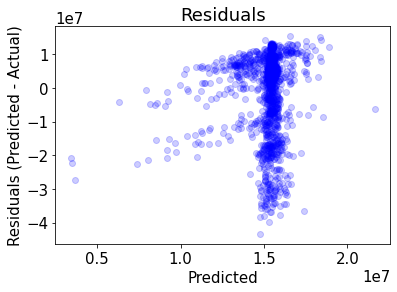

In [39]:
second_model_assumptions = Assumptions(second_model, second_model_data, 'Second Model')
second_model_assumptions.check()

In [40]:
third_model_data = differenced.copy()

third_model_data['terminal_count']  = third_model_data.groupby(['municipality'])['terminal_count']\
                                                        .transform(lambda x: (x - x.mean())/x.std())
third_model_data['casino_agr_log']  =  np.log(third_model_data.casino_agr)

In [41]:
third_formula = 'casino_agr_log~terminal_count+casino_agr_diff'
third_model = multi_level(third_formula, 'municipality', third_model_data)
third_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: casino_agr_log
No. Observations: 1659    Method:             REML          
No. Groups:       7       Scale:              0.1107        
Min. group size:  237     Log-Likelihood:     -573.9066     
Max. group size:  237     Converged:          Yes           
Mean group size:  237.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         16.267    0.267 60.926 0.000 15.744 16.790
terminal_count    -0.049    0.008 -5.982 0.000 -0.065 -0.033
casino_agr_diff    0.000    0.000  1.708 0.088 -0.000  0.000
municipality Var   0.499    0.863                           
============================================================

"""

|    |   rainbow_stat |   rainbow_p |   lagrange_multiplier |   f_stat_p |      ss |   av_var_inflation |
|---:|---------------:|------------:|----------------------:|-----------:|--------:|-------------------:|
|  0 |        1.18431 |  0.00752771 |           0.000542506 | 0.00248813 | 895.552 |            1.00023 |


# Third Model

**formula:** `casino_agr_log~terminal_count+casino_agr_diff`

### Assumptions
- Linearity Assumption was **violated** (p < 0.05)
- Homoscedasticity was **violated** (p < 0.05)

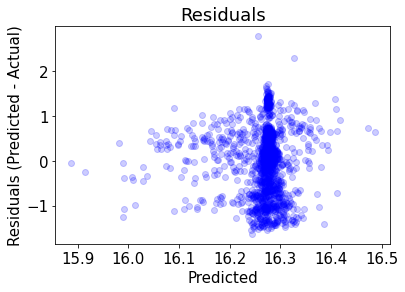

In [42]:
third_model_assumptions = Assumptions(third_model, third_model_data, 'Third Model')
third_model_assumptions.check()

In [43]:
average_terminal_std = differenced['terminal_count'].std()
average_terminal_std = int(int(average_terminal_std))


coefficient = third_model.params.terminal_count
terminal_impact = str(round((np.exp(-coefficient) - 1) * 100)) + '%'
y = third_model_data.casino_agr_log
y_hat = third_model.predict()
mse = mean_squared_error(y, y_hat)
r2 = r2_score(y,y_hat)
table = '''| MSE | R2 | Avg Terminal std | Terminal Impact on AGR |
|-----|----|------------------|------------------------|
| {}  | {} | {}               | {}                     |'''.format(mse, r2, average_terminal_std, terminal_impact)
display(Markdown(table))

| MSE | R2 | Avg Terminal std | Terminal Impact on AGR |
|-----|----|------------------|------------------------|
| 0.5398142438977043  | 0.00402977546164851 | 2               | 5.0%                     |

In [ ]:
the coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9

## Final Model Interpretation

This model finds that on average a 1 standard deviation increase in the number of video gambling terminals will result in a 5% decline in casino revenue. If we consider the standard deviation and mean across communities, this totals to a ≈\$380,172 decline in casino revenue for each video gambling terminal.

# Counter Factual Analysis
The $380,000 number is likely inflated. Let's take the relationship contained without our terminal_count coefficient and calculate the counter factual revenue that, according to our model, a casino would have received if video gambling had not been present.

In [48]:
differenced

,date,terminal_count,municipality,casino_agr,casino_agr_diff
0,2000-03-01,0.0,Alton,10092000.0,239000.0
1,2000-04-01,0.0,Alton,9711000.0,974000.0
2,2000-05-01,0.0,Alton,9538000.0,-381000.0
3,2000-06-01,0.0,Alton,9038000.0,-173000.0
4,2000-07-01,0.0,Alton,10113000.0,-500000.0
...,...,...,...,...,...
1654,2019-07-01,5.0,East Peoria,6519562.0,-541430.0
1655,2019-08-01,0.0,East Peoria,6043648.0,480805.0
1656,2019-09-01,0.0,East Peoria,6037244.0,-475914.0
1657,2019-10-01,-2.0,East Peoria,5588122.0,-6404.0


In [46]:
third_model_data

,date,terminal_count,municipality,casino_agr,casino_agr_diff,casino_agr_log
0,2000-03-01,-0.225653,Alton,10092000.0,239000.0,16.127254
1,2000-04-01,-0.225653,Alton,9711000.0,974000.0,16.088770
2,2000-05-01,-0.225653,Alton,9538000.0,-381000.0,16.070794
3,2000-06-01,-0.225653,Alton,9038000.0,-173000.0,16.016948
4,2000-07-01,-0.225653,Alton,10113000.0,-500000.0,16.129332
...,...,...,...,...,...,...
1654,2019-07-01,2.008501,East Peoria,6519562.0,-541430.0,15.690318
1655,2019-08-01,-0.197313,East Peoria,6043648.0,480805.0,15.614518
1656,2019-09-01,-0.197313,East Peoria,6037244.0,-475914.0,15.613458
1657,2019-10-01,-1.079639,East Peoria,5588122.0,-6404.0,15.536154


In [61]:
def adjusted_revenue(row, std):
    revenue = row.casino_agr
    change = row.terminal_count
    std = change/std
    if change > 0:
        impact = .05 * std * revenue
    else:
        impact = 0
    return revenue + impact

In [62]:
counter_factual = pd.DataFrame()
for municipality in differenced.municipality.unique():
    frame = differenced[differenced.municipality == municipality]
    frame = frame.sort_values(by='date')
    frame.reset_index(drop=True, inplace=True)
    frame['adjusted_agr'] = 0.0
    std = frame.terminal_count.std()
    for idx, row in frame.iterrows():
        update = adjusted_revenue(row, std)
        frame.at[idx, 'adjusted_agr'] = update
    counter_factual = counter_factual.append(frame)

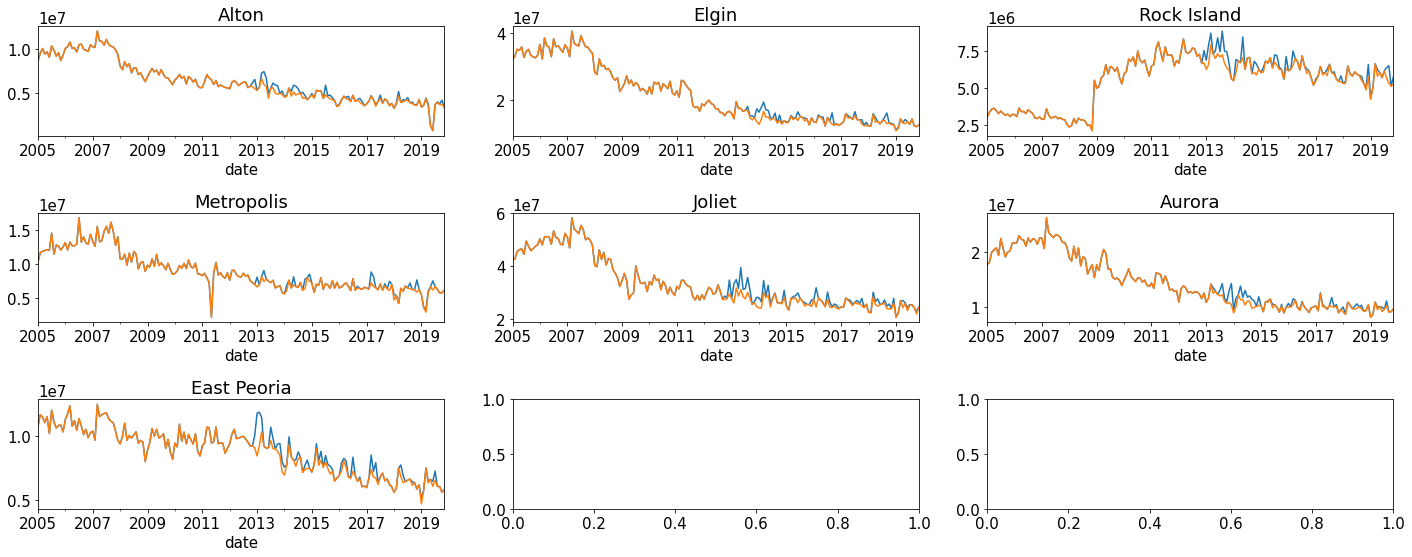

In [63]:
rows = 3
columns = 3

fig, axes = plt.subplots(rows, columns, figsize=(20,8))
for idx in range(len(towns)):
    row, col = subplot_map(idx, columns)
    ax = axes[row, col]
    counter_factual[counter_factual.municipality == towns[idx]]\
            .set_index('date').adjusted_agr.loc['2005':]\
            .plot(label='Adjusted', ax=ax)
    counter_factual[counter_factual.municipality == towns[idx]]\
            .set_index('date').casino_agr.loc['2005':].plot(ax = ax, label='Real')
    
    ax.set_title(towns[idx]);
fig.tight_layout()

Now let's calculate the adjusted tax rate and what portion of this revenue would have been public funds.

In [64]:
def tax_rate(revenue):
    if revenue <= 25000000:
        return .15
    elif revenue <= 50000000:
        return .225
    elif revenue <= 75000000:
        return .275
    elif revenue <= 100000000:
        return .325
    elif revenue <= 150000000:
        return .375
    elif revenue <= 200000000:
        return .45
    elif revenue > 200000000:
        return .5

In [65]:
counter_factual['adjusted_tax'] = counter_factual.adjusted_agr.apply(tax_rate)
counter_factual['observed_tax'] = counter_factual.casino_agr.apply(tax_rate)

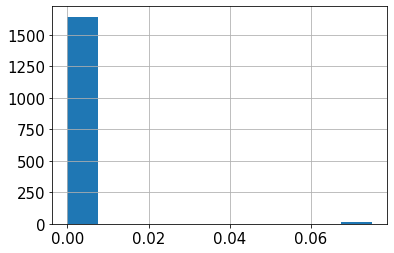

In [66]:
(counter_factual.adjusted_tax - counter_factual.observed_tax).hist()

In [67]:
counter_factual['adjusted_pf'] = counter_factual.adjusted_agr * counter_factual.adjusted_tax
counter_factual['observed_pf'] = counter_factual.casino_agr * counter_factual.observed_tax
counter_factual.adjusted_pf.sum() - counter_factual.observed_pf.sum()

78286474.32399654

In [70]:
78286474.32399654/counter_factual.casino_agr.sum()

0.003106521099718364

In [71]:
counter_factual.adjusted_tax.describe()

count    1659.000000
mean        0.165657
std         0.031524
min         0.150000
25%         0.150000
50%         0.150000
75%         0.150000
max         0.275000
Name: adjusted_tax, dtype: float64

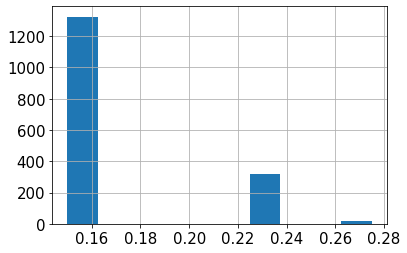

In [72]:
counter_factual.adjusted_tax.hist()